In [1]:
from tensorflow import keras

train_ds = keras.utils.image_dataset_from_directory(
    directory=r"E:\human_data\train",
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=32,
    image_size=(180,180))
val_ds = keras.utils.image_dataset_from_directory(
    directory=r'E:\human_data\test',
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=32,
    image_size=(180,180))

Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 1400 files belonging to 7 classes.
Using 1120 files for training.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.models import Sequential
import sklearn.metrics as metrics

In [3]:
class_names = train_ds.class_names
print(class_names)

['calling', 'clapping', 'eating', 'fighting', 'hugging', 'laughing', 'using_laptop']


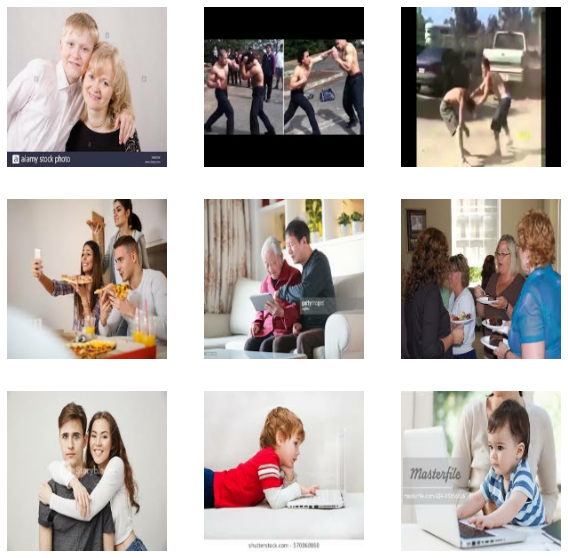

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
 
    plt.axis("off")
    

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(labels_batch)

(32, 180, 180, 3)
(32,)
tf.Tensor([2 5 1 1 4 1 3 2 2 5 5 1 0 6 0 3 4 0 1 6 4 2 3 1 2 5 4 3 1 5 2 5], shape=(32,), dtype=int32)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9907811


In [9]:
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.optimizers import Adam,SGD,RMSprop
import warnings
warnings.filterwarnings('ignore')

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (180,180,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       2

In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Rohit.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/48
175/175 [==============================] - 600s 3s/step - loss: 1.8457 - accuracy: 0.3270 - val_loss: 2.4929 - val_accuracy: 0.2875
Epoch 2/48
175/175 [==============================] - 590s 3s/step - loss: 1.5547 - accuracy: 0.4202 - val_loss: 1.6980 - val_accuracy: 0.4062
Epoch 3/48
175/175 [==============================] - 609s 3s/step - loss: 1.3523 - accuracy: 0.4977 - val_loss: 1.6409 - val_accuracy: 0.4321
Epoch 4/48
175/175 [==============================] - 645s 4s/step - loss: 1.1847 - accuracy: 0.5593 - val_loss: 2.4237 - val_accuracy: 0.3179
Epoch 5/48
175/175 [==============================] - 658s 4s/step - loss: 0.9935 - accuracy: 0.6325 - val_loss: 1.6474 - val_accuracy: 0.4563
Epoch 6/48
175/175 [==============================] - 654s 4s/step - loss: 0.8286 - accuracy: 0.6979 - val_loss: 1.9427 - val_accuracy: 0.4107
Epoch 7/48
175/175 [==============================] - 754s 4s/step - loss: 0.6330 - accuracy: 0.7775 - val_loss: 1.6050 - val_accuracy: 0.4518

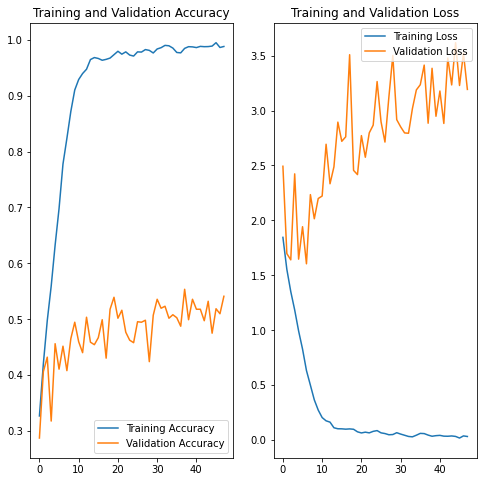

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
from tensorflow.keras.models import save_model
save_model(model, "Rohit.h5")